In [1]:
import datetime
from datetime import datetime
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sqlalchemy as sa
import mlflow
import os
from statsmodels.graphics.tsaplots import plot_acf
import json
import joblib

from sqlalchemy import DECIMAL, Integer, String, DateTime
from sklearn.base import BaseEstimator, TransformerMixin, OneToOneFeatureMixin, clone
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn import metrics
from joblib import Parallel, delayed
from meteostat import Point, Daily


## 1. Obtención de los datos

Nos conectamos a la base de datos usando sqlalchemy y verificamos la conexión. Luego, podemos insertar o consultar datos y utilizamos pandas para manipular y analizar los resultados de manera sencilla

In [2]:
class DatabaseConnection:

    def __init__(
        self,
        username: str,
        password: str,
        database: str = "sandbox",
        host: str = "database-1.cjyy8w6ya3fr.eu-north-1.rds.amazonaws.com",
        port: int = 3306,
        dialect: str = "mysql",
        driver: str = "pymysql",
    ) -> None:
        connection_string = f"{dialect}+{driver}://{username}:{password}@{host}:{port}/{database}"
        self.engine = sa.create_engine(connection_string)

    def reconnect(self):
        self.engine.dispose()
        self.engine = sa.create_engine(self.engine.url)

    def insert_dataframe(self, df: pd.DataFrame, table_name: str, dtype=None) -> None:
        try:
            with self.engine.begin() as conn:
                df.to_sql(table_name, con=conn, if_exists="replace", index=False, dtype=dtype)
        except Exception as e:
            print(f"Error inserting dataframe: {e}")
            self.reconnect()
            raise

    def query_to_df(self, query: str) -> pd.DataFrame:
        with self.engine.connect() as conn:
            df = pd.read_sql_query(query, conn)
            return df

    def check_connection(self) -> bool:
        try:
            with self.engine.connect() as conn:
                conn.execute(sa.text("SELECT 1"))
            return True
        except Exception as e:
            print(f"Connection check failed: {e}")
            return False

def generate_sqlalchemy_dtypes(df: pd.DataFrame) -> dict:
    dtype_map = {}
    for col, dtype in df.dtypes.items():
        if pd.api.types.is_float_dtype(dtype):
            dtype_map[col] = DECIMAL(12, 2)
        elif pd.api.types.is_integer_dtype(dtype):
            dtype_map[col] = Integer()
        elif pd.api.types.is_datetime64_any_dtype(dtype):
            dtype_map[col] = DateTime()
        elif pd.api.types.is_string_dtype(dtype):
            dtype_map[col] = String(255)
    return dtype_map

Establecemos la conexión con la base de datos

In [4]:
# Creamos la conexión a la base de datos con usuario y contraseña
database = DatabaseConnection(DB_USERNAME, DB_PASSWORD)

# Comprobamos la conexión a la base de datos
database.check_connection()


True

Importamos los archivos de Excel usando pandas y los cargamos en DataFrames. Luego, los insertamos en la base de datos usando SQLAlchemy, creando o reemplazando las tablas según sea necesario, para poder trabajar con los datos y analizarlos de manera sencilla.

In [5]:
# Importamos 3 archivos de Excel y los guardamos en dataframes de pandas
df_ventas = pd.read_excel("/workspaces/Datathon/archivos/ArticulosPanaderia.xlsx")
df_calendario = pd.read_excel("/workspaces/Datathon/archivos/Calendario.xlsx")
df_pedidos = pd.read_excel("/workspaces/Datathon/archivos/CantidadPedida.xlsx")

# Cada dataframe se carga en una tabla SQL usando SQLAlchemy (database.engine)
# - "to_sql" crea o reemplaza la tabla en la base de datos
# - if_exists="replace" borra la tabla anterior si existe y crea una nueva
# - index=False evita que se guarde el índice del DataFrame como una columna extra
df_ventas.to_sql("ac_raw_ventas", con=database.engine, if_exists="replace", index=False)
df_calendario.to_sql("ac_raw_calendario", con=database.engine, if_exists="replace", index=False)
df_pedidos.to_sql("ac_raw_pedidos", con=database.engine, if_exists="replace", index=False)


107905

Creamos varias tablas y vistas en la base de datos con consultas SQL: artículos top por familia, calendario de días con festivos y ventas diarias agregadas.
Ejecutamos cada bloque con SQLAlchemy, manejando errores, dejando los datos listos para análisis y consultas.

In [6]:
# Lista de consultas SQL divididas en bloques para crear tablas y vistas en sandbox
consulta = [
    # Bloque 1: Crear tabla con los artículos top por familia según importe
    """
    DROP TABLE IF EXISTS sandbox.ac_articulos_top;
    """,
    """
    CREATE TABLE sandbox.ac_articulos_top AS
    SELECT
        Articulo,
        FAMILIA,
        SUM(importe) AS importe_total,
        ROW_NUMBER() OVER (PARTITION BY FAMILIA ORDER BY SUM(importe) DESC) AS orden
    FROM sandbox.ac_raw_ventas
    WHERE FechaVenta >= '2021-05-01'
    GROUP BY Articulo, FAMILIA;
    """,

    # Bloque 2: Crear calendario de días usando CTE recursivo
    """
    DROP TABLE IF EXISTS sandbox.ac_calendario_dias;
    """,
    """
    SET @@cte_max_recursion_depth = 4000;  -- Ajusta profundidad máxima del CTE recursivo
    """,
    """
    CREATE TABLE sandbox.ac_calendario_dias AS
    WITH RECURSIVE cte_ac_calendario AS (
        SELECT DATE('2017-01-01') AS calendar_date
        UNION ALL
        SELECT DATE_ADD(calendar_date, INTERVAL 1 DAY)
        FROM cte_ac_calendario
        WHERE DATE_ADD(calendar_date, INTERVAL 1 DAY) <= DATE('2023-12-31')
    )
    SELECT
        calendar_date AS fecha,
        YEAR(calendar_date) AS fx_anno,
        MONTH(calendar_date) AS fx_mes,
        DAY(calendar_date) AS fx_day,
        DATE_FORMAT(calendar_date, '%Y%m') AS fx_anno_mes,
        DATE_FORMAT(calendar_date, '%x-%v') AS semana
    FROM cte_ac_calendario;
    """,

    # Bloque 3: Completar calendario con los días festivos
    """
    DROP TABLE IF EXISTS sandbox.ac_calendario_completo;
    """,
    """
    CREATE TABLE sandbox.ac_calendario_completo AS
    SELECT
        base.*,
        festivos.festivo
    FROM sandbox.ac_calendario_dias base
    LEFT JOIN (
        SELECT
            a.*,
            ROW_NUMBER() OVER (PARTITION BY a.fecha ORDER BY a.festivo) AS orden
        FROM sandbox.ac_raw_calendario a
    ) festivos ON base.fecha = festivos.fecha AND festivos.orden = 1;
    """,

    # Bloque 4: Crear tabla con ventas diarias agregadas por artículo y familia
    """
    DROP TABLE IF EXISTS sandbox.ac_ventas_diarias;
    """,
    """
    CREATE TABLE sandbox.ac_ventas_diarias AS
    SELECT
        base.familia,
        base.tipo,
        base.fechaVenta,
        calendario.festivo,
        base.articulo,
        SUM(base.precio * base.cantidad) / NULLIF(SUM(base.cantidad), 0) AS precio,
        articulos.orden AS orden_articulo_familia,
        CASE WHEN base.fechaVenta >= DATE('2021-05-01') THEN 'S' ELSE 'N' END AS in_fecha_estudio,
        SUM(base.cantidad) AS cantidad,
        SUM(base.importe) AS importe
    FROM sandbox.ac_raw_ventas base
    INNER JOIN sandbox.ac_calendario_completo calendario ON base.fechaVenta = calendario.fecha
    INNER JOIN sandbox.ac_articulos_top articulos ON base.familia = articulos.familia AND base.articulo = articulos.articulo
    GROUP BY base.familia, base.tipo, base.fechaVenta, calendario.festivo, base.articulo, articulos.orden;
    """,

    # Bloque 5: Vista con ventas de estudio completo (solo los top 5 artículos por familia)
    """
    DROP VIEW IF EXISTS sandbox.ac_ventas_diarias_estudio_completo;
    """,
    """
    CREATE VIEW sandbox.ac_ventas_diarias_estudio_completo AS
    SELECT *
    FROM sandbox.ac_ventas_diarias
    WHERE tipo = 'VENTA'
      AND in_fecha_estudio = 'S'
      AND orden_articulo_familia <= 5;
    """,

    # Bloque 6: Vista con ventas de estudio limitado a fechas anteriores a 2023-05-01
    """
    DROP VIEW IF EXISTS sandbox.ac_ventas_diarias_estudio;
    """,
    """
    CREATE VIEW sandbox.ac_ventas_diarias_estudio AS
    SELECT *
    FROM sandbox.ac_ventas_diarias
    WHERE tipo = 'VENTA'
      AND in_fecha_estudio = 'S'
      AND fechaVenta < DATE('2023-05-01')
      AND orden_articulo_familia <= 5;
    """
]

# Ejecutamos cada bloque de consultas en la base de datos
from sqlalchemy import text

with database.engine.begin() as conn:
    for bloque in consulta:
        try:
            # Mostrar el inicio de la consulta que se va a ejecutar
            print(f"Ejecutando bloque:\n{bloque.strip()[:100]}...\n")
            conn.execute(text(bloque))
        except Exception as e:
            # Si falla, mostrar error y salir
            print(f"Error ejecutando bloque:\n{bloque.strip()[:100]}...\nError: {e}")
            conn.rollback()
            break

print("✅ Script ejecutado correctamente.")


Ejecutando bloque:
DROP TABLE IF EXISTS sandbox.ac_articulos_top;...

Ejecutando bloque:
CREATE TABLE sandbox.ac_articulos_top AS
    SELECT
        Articulo,
        FAMILIA,
        SUM(i...

Ejecutando bloque:
DROP TABLE IF EXISTS sandbox.ac_calendario_dias;...

Ejecutando bloque:
SET @@cte_max_recursion_depth = 4000;  -- Ajusta profundidad máxima del CTE recursivo...

Ejecutando bloque:
CREATE TABLE sandbox.ac_calendario_dias AS
    WITH RECURSIVE cte_ac_calendario AS (
        SELECT ...

Ejecutando bloque:
DROP TABLE IF EXISTS sandbox.ac_calendario_completo;...

Ejecutando bloque:
CREATE TABLE sandbox.ac_calendario_completo AS
    SELECT
        base.*,
        festivos.festivo
 ...

Ejecutando bloque:
DROP TABLE IF EXISTS sandbox.ac_ventas_diarias;...

Ejecutando bloque:
CREATE TABLE sandbox.ac_ventas_diarias AS
    SELECT
        base.familia,
        base.tipo,
      ...

Ejecutando bloque:
DROP VIEW IF EXISTS sandbox.ac_ventas_diarias_estudio_completo;...

Ejecutando bloque:


Definimos una consulta SQL para traer los datos de ventas y la ejecutamos usando SQLAlchemy. Guardamos el resultado en un DataFrame de pandas, lo que nos permite trabajar con los datos y analizarlos de manera sencilla en Python.

In [7]:
# Definimos una consulta SQL para traer información de ventas
# Seleccionamos columnas como familia, artículo, fecha, precio, cantidad e importe
query = """
    SELECT familia,
        articulo,
        fechaVenta AS fecha_venta,  # renombramos para que sea más fácil de usar en Python
        festivo,
        precio,
        cantidad,
        importe,
        orden_articulo_familia
    FROM ac_ventas_diarias_estudio
"""

# Ejecutamos la consulta y guardamos el resultado en un DataFrame
ventas = database.query_to_df(query)

# Mostramos información general del DataFrame: cuántas filas y columnas tiene, tipos de datos y si hay valores nulos
ventas.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10322 entries, 0 to 10321
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   familia                 10322 non-null  object        
 1   articulo                10322 non-null  int64         
 2   fecha_venta             10322 non-null  datetime64[ns]
 3   festivo                 809 non-null    object        
 4   precio                  10322 non-null  float64       
 5   cantidad                10322 non-null  float64       
 6   importe                 10322 non-null  float64       
 7   orden_articulo_familia  10322 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 645.3+ KB


In [8]:
ventas.head()

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia
0,BOLLERIA,3960,2021-05-20,None,2.318,177.0,410.2860,1
1,BOLLERIA,6425,2021-08-24,None,31.364,8.7,272.8672,2
2,BOLLERIA,5803,2021-09-27,None,3.000,30.0,90.0000,5
3,BOLLERIA,3880,2021-10-09,None,3.000,108.0,324.0000,3
4,BOLLERIA,5803,2021-10-11,None,3.000,81.0,243.0000,5


In [9]:
# Convertimos la columna 'fecha_venta' a tipo fecha (datetime) 
# para poder trabajar con fechas fácilmente (filtrar, agrupar, etc.)
ventas["fecha_venta"] = pd.to_datetime(ventas["fecha_venta"])

# Convertimos la columna 'articulo' a entero
# Esto asegura que los códigos de artículo sean números y no texto
ventas["articulo"] = ventas["articulo"].astype(int)


### 1.1 Consulta a meteostat API

Consultamos la API de Meteostat para obtener los datos del clima y los guardamos en un DataFrame de pandas, para luego combinar esta información con los datos de ventas y analizarlos de manera sencilla.

In [10]:
class DailyWeatherData:
    # Ubicación de la panadería (latitud y longitud)
    panaderia = Point(*LOCATION)  # LOCATION debe ser una tupla (lat, lon)

    # Columnas importantes que queremos de los datos meteorológicos
    IMP_COLUMNS = ['tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres']

    # Constructor: define el rango de fechas para consultar el clima
    def __init__(self, start, end=datetime.now()):
        self.start = start  # fecha de inicio
        self.end = end      # fecha de fin (por defecto hoy)

    # Método para obtener los datos diarios del clima
    def get_weather_data(self):
        daily_data = Daily(self.panaderia, self.start, self.end)  # objeto para consultar clima
        data = daily_data.fetch()  # obtenemos los datos
        # Seleccionamos solo las columnas importantes, añadimos sufijo '_w' y reseteamos índice
        return data[self.IMP_COLUMNS].add_suffix('_w').reset_index()


In [11]:
# Definimos el inicio del periodo según la primera fecha de ventas
start = ventas["fecha_venta"].min()

# Definimos el final del periodo según la última fecha de ventas
end = ventas["fecha_venta"].max()

# Creamos una instancia de la clase DailyWeatherData con ese rango de fechas
weather_query = DailyWeatherData(start, end)

# Obtenemos los datos del clima para ese periodo
weather = weather_query.get_weather_data()

# Mostramos el DataFrame con la información del tiempo
weather

,time,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
0,2021-05-01,17.2,11.9,22.8,0.0,<NA>,14.2,1014.0
1,2021-05-02,16.3,10.8,23.2,0.0,<NA>,15.7,1015.9
2,2021-05-03,15.3,12.7,20.1,6.5,<NA>,9.7,1017.7
3,2021-05-04,16.5,12.0,20.9,0.0,<NA>,12.1,1018.0
4,2021-05-05,16.7,12.3,21.7,0.0,<NA>,13.8,1016.5
...,...,...,...,...,...,...,...,...
725,2023-04-26,20.3,15.5,26.0,0.0,<NA>,10.6,1014.0
726,2023-04-27,19.1,15.0,24.5,0.0,<NA>,9.9,1015.1
727,2023-04-28,20.8,16.6,26.7,0.0,<NA>,14.3,1015.2
728,2023-04-29,25.6,18.7,34.3,0.0,<NA>,16.9,1015.4


### 1.3 Join datos ventas y tiempo

Unimos los datos de ventas con los datos meteorológicos usando la columna de fecha como clave. Esto nos permite tener en un solo DataFrame de pandas la información de ventas junto con las condiciones del clima, lista para análisis y visualizaciones.

In [12]:
# Hacemos un "merge" o unión entre ventas y clima usando la fecha como clave
# Después eliminamos la columna 'time' que quedó redundante
vt = pd.merge(ventas, weather,
              left_on=["fecha_venta"], right_on=["time"],
              how="inner").drop("time", axis=1)

# Ordenamos el DataFrame primero por artículo y luego por fecha
# Esto ayuda a tener los datos en orden cronológico por cada producto
vt.sort_values(["articulo", "fecha_venta"], inplace=True)

# Mostramos las primeras 5 filas para verificar cómo quedó
vt.head(5)

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
877,PANADERIA,417,2021-05-01,None,4.038,72.0,290.736,5,17.2,11.9,22.8,0.0,<NA>,14.2,1014.0
9725,PANADERIA,417,2021-05-02,Día de la Madre,4.038,81.0,327.078,5,16.3,10.8,23.2,0.0,<NA>,15.7,1015.9
3681,PANADERIA,417,2021-05-03,Día de la Cruz,4.038,90.0,363.420,5,15.3,12.7,20.1,6.5,<NA>,9.7,1017.7
6261,PANADERIA,417,2021-05-04,None,4.038,84.0,339.192,5,16.5,12.0,20.9,0.0,<NA>,12.1,1018.0
6178,PANADERIA,417,2021-05-05,None,4.038,84.0,339.192,5,16.7,12.3,21.7,0.0,<NA>,13.8,1016.5


## 2. Modelos predictivos

Los modelos predictivos son herramientas que utilizan los datos históricos para predecir valores futuros de una variable objetivo.
Se entrenan con patrones y relaciones existentes en los datos, y luego se utilizan para hacer pronósticos, estimaciones o tomar decisiones informadas.

### 2.1 Convertimos la serie a formato supervisado

Convertimos la serie temporal de ventas a formato supervisado, es decir, organizamos los datos de manera que cada fila tenga las observaciones pasadas como variables y la venta futura como variable objetivo, para poder entrenar modelos predictivos de manera sencilla.

In [13]:
# Convierte una serie temporal en formato supervisado creando variables rezagadas (lags) para predecir el valor de la columna objetivo.
def series_to_supervised(
    df: pd.DataFrame,
    target_colum: str = "cantidad",
    daily_lag: int = 1,
    weekly_lag: int = 1,
) -> pd.DataFrame:
     # Copiamos el DataFrame para no modificar el original
    final_df = df.copy()

    # Columna objetivo a la que le vamos a crear los rezagos
    target_feature = final_df[target_colum]

    # Función interna para crear columnas rezagadas
    def create_shifted_feature(lag: int, frequency: int, freq_label: str):
        # Desplazamos la columna objetivo según el lag y la frecuencia
        shifted_feature = target_feature.shift(lag * frequency)
        # Nombre de la nueva columna, ej: "cantidad (t-1 days)"
        feature_name = f"{target_feature.name} (t-{lag} {freq_label})"
        # Agregamos la nueva columna al DataFrame final
        final_df[feature_name] = shifted_feature

    # Creamos rezagos semanales
    for lag in range(weekly_lag, 0, -1):
        create_shifted_feature(lag, 7, "weeks")

    # Creamos rezagos diarios
    for lag in range(daily_lag, 0, -1):
        create_shifted_feature(lag, 1, "days")

    return final_df

### 2.2 Preprocesamiento de los datos

El preprocesamiento consiste en preparar los datos antes de modelarlos.
Incluye tareas como: limpiar valores faltantes, normalizar o escalar variables, convertir datos a formatos adecuados y crear nuevas variables.
Esto asegura que los datos estén listos y consistentes para entrenar modelos predictivos de manera eficaz.

### 2.2.1 Extraemos info de la fecha de venta

In [14]:
def add_date_columns(df: pd.DataFrame, date_column: str = "fecha_venta") -> pd.DataFrame:
    # Extraemos información de la fecha y la agregamos como nuevas columnas
    df["day"] = df[date_column].dt.day            # día del mes
    df["month"] = df[date_column].dt.month        # mes
    df["year"] = df[date_column].dt.year          # año
    df["dayofweek"] = df[date_column].dt.dayofweek + 1  # día de la semana (1=lunes, 7=domingo)
    df["isWeekend"] = (df["dayofweek"] >= 6).astype(int)  # 1 si es fin de semana, 0 si no
    return df

# Creamos una copia del DataFrame para no modificar el original
tabla_tmp = vt.copy()

# Aplicamos la función y mostramos las primeras filas
add_date_columns(tabla_tmp).head()


,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w,day,month,year,dayofweek,isWeekend
877,PANADERIA,417,2021-05-01,None,4.038,72.0,290.736,5,17.2,11.9,22.8,0.0,<NA>,14.2,1014.0,1,5,2021,6,1
9725,PANADERIA,417,2021-05-02,Día de la Madre,4.038,81.0,327.078,5,16.3,10.8,23.2,0.0,<NA>,15.7,1015.9,2,5,2021,7,1
3681,PANADERIA,417,2021-05-03,Día de la Cruz,4.038,90.0,363.420,5,15.3,12.7,20.1,6.5,<NA>,9.7,1017.7,3,5,2021,1,0
6261,PANADERIA,417,2021-05-04,None,4.038,84.0,339.192,5,16.5,12.0,20.9,0.0,<NA>,12.1,1018.0,4,5,2021,2,0
6178,PANADERIA,417,2021-05-05,None,4.038,84.0,339.192,5,16.7,12.3,21.7,0.0,<NA>,13.8,1016.5,5,5,2021,3,0


### 2.2.2 Indicamos si es festivo o no

In [15]:
def add_holiday_column(df: pd.DataFrame, holiday_column_name: str = "festivo") -> pd.DataFrame:
    # Hacemos una copia del DataFrame para no modificar el original
    df = df.copy()
    
    # Creamos una nueva columna "isHoliday":
    # - 1 si hay un festivo (valor no nulo en la columna 'festivo')
    # - 0 si no hay festivo (valor nulo)
    df["isHoliday"] = df[holiday_column_name].notna().astype(int)
    
    return df

# Creamos una copia del DataFrame
tabla_tmp = vt.copy()

# Aplicamos la función y mostramos las primeras filas
add_holiday_column(tabla_tmp, holiday_column_name="festivo").head()


,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w,isHoliday
877,PANADERIA,417,2021-05-01,None,4.038,72.0,290.736,5,17.2,11.9,22.8,0.0,<NA>,14.2,1014.0,0
9725,PANADERIA,417,2021-05-02,Día de la Madre,4.038,81.0,327.078,5,16.3,10.8,23.2,0.0,<NA>,15.7,1015.9,1
3681,PANADERIA,417,2021-05-03,Día de la Cruz,4.038,90.0,363.420,5,15.3,12.7,20.1,6.5,<NA>,9.7,1017.7,1
6261,PANADERIA,417,2021-05-04,None,4.038,84.0,339.192,5,16.5,12.0,20.9,0.0,<NA>,12.1,1018.0,0
6178,PANADERIA,417,2021-05-05,None,4.038,84.0,339.192,5,16.7,12.3,21.7,0.0,<NA>,13.8,1016.5,0


### 2.2.3 Indicamos si lluve o no

In [16]:
def add_raining_column(df: pd.DataFrame, rain_column_name: str = "prcp_w") -> pd.DataFrame:
    # Hacemos una copia para no modificar el DataFrame original
    df = df.copy()
    
    # Reemplazamos valores NaN en la columna de lluvia por 0
    df[rain_column_name] = df[rain_column_name].fillna(0)
    
    # Creamos una nueva columna "isRaining":
    # - 1 si hubo lluvia (valor > 0)
    # - 0 si no hubo lluvia
    df["isRaining"] = (df[rain_column_name] > 0).astype(int)
    
    return df

# Creamos una copia del DataFrame
tabla_tmp = vt.copy()

# Aplicamos la función y mostramos las primeras filas
add_raining_column(tabla_tmp, rain_column_name="prcp_w").head()


,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w,isRaining
877,PANADERIA,417,2021-05-01,None,4.038,72.0,290.736,5,17.2,11.9,22.8,0.0,<NA>,14.2,1014.0,0
9725,PANADERIA,417,2021-05-02,Día de la Madre,4.038,81.0,327.078,5,16.3,10.8,23.2,0.0,<NA>,15.7,1015.9,0
3681,PANADERIA,417,2021-05-03,Día de la Cruz,4.038,90.0,363.420,5,15.3,12.7,20.1,6.5,<NA>,9.7,1017.7,1
6261,PANADERIA,417,2021-05-04,None,4.038,84.0,339.192,5,16.5,12.0,20.9,0.0,<NA>,12.1,1018.0,0
6178,PANADERIA,417,2021-05-05,None,4.038,84.0,339.192,5,16.7,12.3,21.7,0.0,<NA>,13.8,1016.5,0


## 3. Creación del Pipeline 

Creamos un pipeline para automatizar el flujo de procesamiento y modelado de los datos.
Incluye preprocesamiento, transformación de variables y entrenamiento del modelo en un solo proceso, lo que facilita reproducibilidad, mantenimiento y evaluación de los modelos predictivos.

### 3.1 Preprocesamiento de los datos de entrada

Integramos todas las transformaciones realizadas previamente en un Pipeline de Procesamiento de Datos, de manera que se apliquen de forma secuencial y automática

In [17]:
class PreprocessTransformer(BaseEstimator, TransformerMixin, OneToOneFeatureMixin):
    def __init__(self, location: tuple[int, int]):
        self.location = location  # almacena la ubicación de la panadería (lat, lon)

    # El método fit no hace nada en este caso, solo devuelve self
    def fit(self, X: pd.DataFrame, y: pd.Series | None = None):
        return self

    # Método transform aplica las funciones de preprocesamiento
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()  # trabajamos sobre una copia para no modificar el original
        X = add_date_columns(X)  # añade columnas de día, mes, año, fin de semana, etc.
        X = add_holiday_column(X, holiday_column_name="festivo")  # añade columna isHoliday
        X = add_raining_column(X, rain_column_name="prcp_w")  # añade columna isRaining
        return X

# Creamos una instancia del transformador
preprocessor = PreprocessTransformer(location=LOCATION)

In [18]:
# Creamos la instancia del transformador de preprocesamiento
preprocessor = PreprocessTransformer(location=LOCATION)

# Aplicamos el preprocesamiento al DataFrame df
# Esto añade columnas de fecha, si es festivo y si llovió
tabla_procesada = preprocessor.transform(vt)

# Mostramos las primeras filas del DataFrame ya procesado
tabla_procesada.head()


,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,...,wdir_w,wspd_w,pres_w,day,month,year,dayofweek,isWeekend,isHoliday,isRaining
877,PANADERIA,417,2021-05-01,None,4.038,72.0,290.736,5,17.2,11.9,...,<NA>,14.2,1014.0,1,5,2021,6,1,0,0
9725,PANADERIA,417,2021-05-02,Día de la Madre,4.038,81.0,327.078,5,16.3,10.8,...,<NA>,15.7,1015.9,2,5,2021,7,1,1,0
3681,PANADERIA,417,2021-05-03,Día de la Cruz,4.038,90.0,363.420,5,15.3,12.7,...,<NA>,9.7,1017.7,3,5,2021,1,0,1,1
6261,PANADERIA,417,2021-05-04,None,4.038,84.0,339.192,5,16.5,12.0,...,<NA>,12.1,1018.0,4,5,2021,2,0,0,0
6178,PANADERIA,417,2021-05-05,None,4.038,84.0,339.192,5,16.7,12.3,...,<NA>,13.8,1016.5,5,5,2021,3,0,0,0


### 3.2 Eliminar los valores nulos y Normalización de los datos de entrada


En este paso completamos los valores faltantes reemplazándolos por la media de cada columna y, además, transformamos las variables: las categóricas se codifican con OneHotEncoder y las numéricas se normalizan con MinMaxScaler.

In [19]:
# Transformador para columnas numéricas
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),  # rellena valores faltantes con la media
    ("scaler", MinMaxScaler())                    # normaliza los valores entre 0 y 1
])

# Transformador para columnas categóricas
categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))  
    # convierte categorías en columnas binarias (one-hot)
    # "handle_unknown=ignore" evita errores si aparecen categorías nuevas
    # "sparse_output=False" devuelve un array denso en vez de formato disperso
])

# Preprocesador que aplica automáticamente transformaciones según el tipo de columna
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, make_column_selector(dtype_include=np.number)),  # columnas numéricas
        ("cat", categorical_transformer, make_column_selector(dtype_exclude=np.number)) # columnas categóricas
    ],
    remainder="drop"  # descartamos las columnas que no se transforman
)

### 3.3 Incluimos el modelo de Machine Learning


Dado que nuestro objetivo es predecir un valor numérico, utilizaremos un modelo de regresión. En este caso, aplicaremos el LinearRegression de Scikit-Learn.

In [20]:
from sklearn.linear_model import LinearRegression
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.ensemble import GradientBoostingRegressor
#from sklearn.neural_network import MLPRegressor
#from sklearn.neighbors import KNeighborsRegressor

model = LinearRegression()
#model = DecisionTreeRegressor()
#model = RandomForestRegressor(n_estimators=300, max_depth=12, random_state=42, n_jobs=-1)
#model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
#model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500)
#model = KNeighborsRegressor(n_neighbors=10)

model

LinearRegression()

### 3.4 Creamos el pipeline para las variables de entrada


Integramos los pasos anteriores en un pipeline secuencial, que se encargará de procesar automáticamente los datos de entrada y luego entrenar el modelo con ellos.

In [21]:
# Creamos un pipeline que une preprocesamiento y modelo
input_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),  # aplica las funciones de fecha, festivo y lluvia
    ("model", model)                 # entrena el modelo de regresión (LinearRegression en este caso)
])

# Configuramos el pipeline para que devuelva resultados como DataFrame de pandas
input_pipeline.set_output(transform="pandas")


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6188d11490>),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6195306ad0>)])),
                ('model', LinearRegression())])

### 3.5 Normalizamos la variable objetivo


Finalmente, aplicamos el mismo OneHotEncoder usado en los datos de entrada para transformar la variable objetivo, sin volver a ajustarlo. Esto garantiza que el target tenga el mismo formato que las variables de entrada, facilitando la predicción y evaluación del modelo.

In [22]:
# Escalador para la variable objetivo (cantidad de ventas) entre 0 y 1
target_feature_scaler = MinMaxScaler(feature_range=(0, 1))

# Pipeline final que combina preprocesamiento, modelo y escalado de la variable objetivo
final_pipeline = TransformedTargetRegressor(
    regressor=input_pipeline,    # pipeline que hace preprocesamiento + modelo
    transformer=target_feature_scaler,  # escala la variable objetivo antes de entrenar
)

final_pipeline  # mostrar la configuración del pipeline final

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('num',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        SimpleImputer()),
                                                                                                       ('scaler',
                                                                                                        MinMaxScaler())]),
                                                                                       <sklearn.compose._column_transformer.make_column_selector object at 0x7f6188d11490>),
                                                                                      ('cat',
                                                                                       Pipeline(steps=[('encoder',
                                                                                                        OneHotEncoder(handle_unknown='ignore',
                                                                                                                      sparse_output=False))]),
                                                                                       <sklearn.compose._column_transformer.make_column_selector object at 0x7f6195306ad0>)])),
                                                     ('model',
                                                      LinearRegression())]),
                           transformer=MinMaxScaler())

## 4. Entrenamos el modelo


Entrenamos los modelos de manera individual para cada producto usando el pipeline de transformación de datos definido previamente. Se fijó un horizonte de prueba de 30 días, de modo que cada modelo se evalúa con las ventas más recientes y se entrena con los datos anteriores. Posteriormente, los modelos individuales se integran en un ensemble para facilitar predicciones automáticas y consistentes para todos los productos seleccionados.

### 4.1 Pequeña limpieza previa de los datos

In [23]:
# Eliminamos columnas que ya no necesitamos del DataFrame
tabla_procesada.drop(columns=['importe','precio','orden_articulo_familia', 'wdir_w','tavg_w','tmin_w','tmax_w','wspd_w','pres_w'], inplace=True)
tabla_procesada.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10322 entries, 877 to 5276
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   familia      10322 non-null  object        
 1   articulo     10322 non-null  int64         
 2   fecha_venta  10322 non-null  datetime64[ns]
 3   festivo      809 non-null    object        
 4   cantidad     10322 non-null  float64       
 5   prcp_w       10322 non-null  Float64       
 6   day          10322 non-null  int32         
 7   month        10322 non-null  int32         
 8   year         10322 non-null  int32         
 9   dayofweek    10322 non-null  int32         
 10  isWeekend    10322 non-null  int64         
 11  isHoliday    10322 non-null  int64         
 12  isRaining    10322 non-null  int64         
dtypes: Float64(1), datetime64[ns](1), float64(1), int32(4), int64(4), object(2)
memory usage: 977.8+ KB


### 4.2 Iniciar el servidor de MLFlow


In [24]:
# Nombre del experimento en MLflow
MLFLOW_EXPERIMENT_NAME = "Datathon"

# Dirección del servidor de tracking de MLflow
MLFLOW_TRACKING_URI = "http://localhost:5000"

# Configuramos MLflow para que registre los experimentos en el servidor indicado
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

# Creamos o seleccionamos el experimento donde se guardarán los resultados
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)

# Activamos el autologging de scikit-learn
# Esto registra automáticamente métricas, parámetros y modelos entrenados
mlflow.sklearn.autolog()


2025/08/28 12:58:47 INFO mlflow.tracking.fluent: Experiment with name 'Datathon' does not exist. Creating a new experiment.


### 4.3 Entrenamos y evaluamos el modelo


Para cada producto seleccionado, entrenamos un modelo individual utilizando el pipeline de transformación de datos definido previamente. Cada modelo se entrena con los datos históricos anteriores a un horizonte de prueba de 30 días y se evalúa con las ventas más recientes. Registramos las métricas de rendimiento y guardamos tanto el modelo como las predicciones correspondientes.

Posteriormente, todas las predicciones y modelos individuales se organizan en un manifest, lo que permite combinarlos en un ensemble. Este enfoque facilita realizar predicciones automáticas y consistentes para todos los productos, ya que cada modelo se encarga de su producto específico dentro del conjunto final.

In [25]:
# Lista de artículos que vamos a procesar
PRODUCTS = [3960, 6425, 3880, 6286, 5803, 968, 1043, 900, 1084, 417, 5404, 5403, 6523, 6451, 6549]

# Fecha de corte para separar entrenamiento y test
horizont = datetime(2023, 4, 19)

# Filtramos el DataFrame original para quedarnos solo con los artículos que nos interesan
df = tabla_procesada[tabla_procesada["articulo"].isin(PRODUCTS)].copy()

# Asegurarnos de que la columna de fechas sea del tipo datetime
df['fecha_venta'] = pd.to_datetime(df['fecha_venta'])

# Ordenamos primero por artículo y luego por fecha de venta para mantener el orden temporal
df.sort_values(["articulo", "fecha_venta"], inplace=True)
df.reset_index(drop=True, inplace=True)

# Convertimos todas las columnas enteras a float64, porque algunos modelos no aceptan int nativos
for col in df.select_dtypes(include='int').columns:
    df[col] = df[col].astype('float64')

# Guardamos copias de las columnas de identificación por si las necesitamos más tarde
articulos = df["articulo"].copy()
familias = df["familia"].copy()
fechas = df["fecha_venta"].copy()

# Transformamos la serie temporal a formato supervisado
# Esto crea variables con rezagos diarios y semanales para predecir "cantidad"
df_supervised = series_to_supervised(
    df.drop(columns=["articulo", "familia"]),  # quitamos identificadores
    daily_lag=7,                               # usamos los últimos 7 días
    weekly_lag=4,                              # y las últimas 4 semanas
    target_colum="cantidad"                     # la variable objetivo
)

# Restauramos las columnas de identificación para no perder información
df_supervised["articulo"] = articulos.values[:len(df_supervised)]
df_supervised["familia"] = familias.values[:len(df_supervised)]
df_supervised["fecha_venta"] = fechas.values[:len(df_supervised)]

# Reemplazamos df original por el df ya transformado a supervisado
df = df_supervised

# Creamos carpeta para guardar los modelos si no existe
os.makedirs("product_models", exist_ok=True)

# Diccionario que guardará información de cada modelo (para luego usarlo como manifest)
manifest = {
    "schema_version": 1,
    "products": {}
}

# Lista vacía donde iremos almacenando las predicciones de cada producto
all_predictions = []


Producto 3960 -> MAE: 2.36, R²: 1.00
🏃 View run funny-fish-629 at: http://localhost:5000/#/experiments/325443221124704435/runs/f951f19cf546421ebc5a46838b5e3cde
🧪 View experiment at: http://localhost:5000/#/experiments/325443221124704435
Producto 6425 -> MAE: 0.54, R²: 0.99
🏃 View run selective-kit-69 at: http://localhost:5000/#/experiments/325443221124704435/runs/224d4be3e6f04f46b50b0c7798a0839e
🧪 View experiment at: http://localhost:5000/#/experiments/325443221124704435
Producto 3880 -> MAE: 4.90, R²: 0.98
🏃 View run nimble-asp-890 at: http://localhost:5000/#/experiments/325443221124704435/runs/291147aad1784b358865e8419b4c06c6
🧪 View experiment at: http://localhost:5000/#/experiments/325443221124704435
Producto 6286 -> MAE: 2.76, R²: 0.99
🏃 View run nimble-tern-891 at: http://localhost:5000/#/experiments/325443221124704435/runs/1adb1330058d4a96aac463a2053ff0ba
🧪 View experiment at: http://localhost:5000/#/experiments/325443221124704435
Producto 5803 -> MAE: 1.94, R²: 0.99
🏃 View run i

🏃 View run grandiose-colt-647 at: http://localhost:5000/#/experiments/325443221124704435/runs/9477a669bdad4311b79e7a26c5dbf6e7
🧪 View experiment at: http://localhost:5000/#/experiments/325443221124704435
Producto 5403 -> MAE: 0.77, R²: 1.00
🏃 View run overjoyed-dove-873 at: http://localhost:5000/#/experiments/325443221124704435/runs/6a7670ef288b4a1bb590dfdc6ad625c4
🧪 View experiment at: http://localhost:5000/#/experiments/325443221124704435
Producto 6523 -> MAE: 0.37, R²: 1.00
🏃 View run whimsical-kit-271 at: http://localhost:5000/#/experiments/325443221124704435/runs/d3c8fdc7d1ee4aa190ef8fd6aaa3ac71
🧪 View experiment at: http://localhost:5000/#/experiments/325443221124704435
Producto 6451 -> MAE: 0.36, R²: 1.00
🏃 View run blushing-kit-484 at: http://localhost:5000/#/experiments/325443221124704435/runs/f239e133f8864e129e97ca48ddb4a3c1
🧪 View experiment at: http://localhost:5000/#/experiments/325443221124704435
Producto 6549 -> MAE: 0.84, R²: 0.98
🏃 View run selective-lamb-666 at: http:

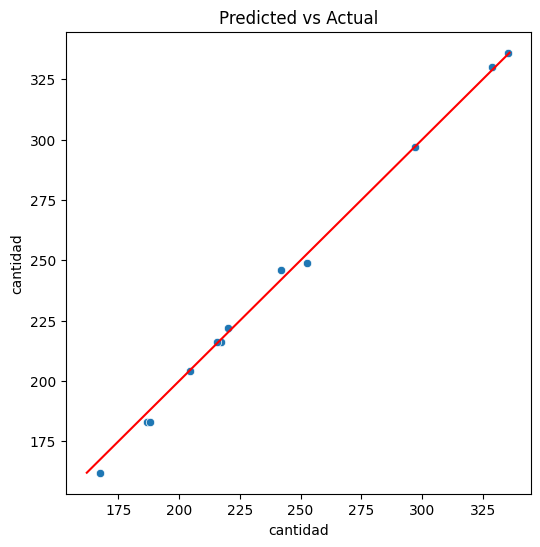

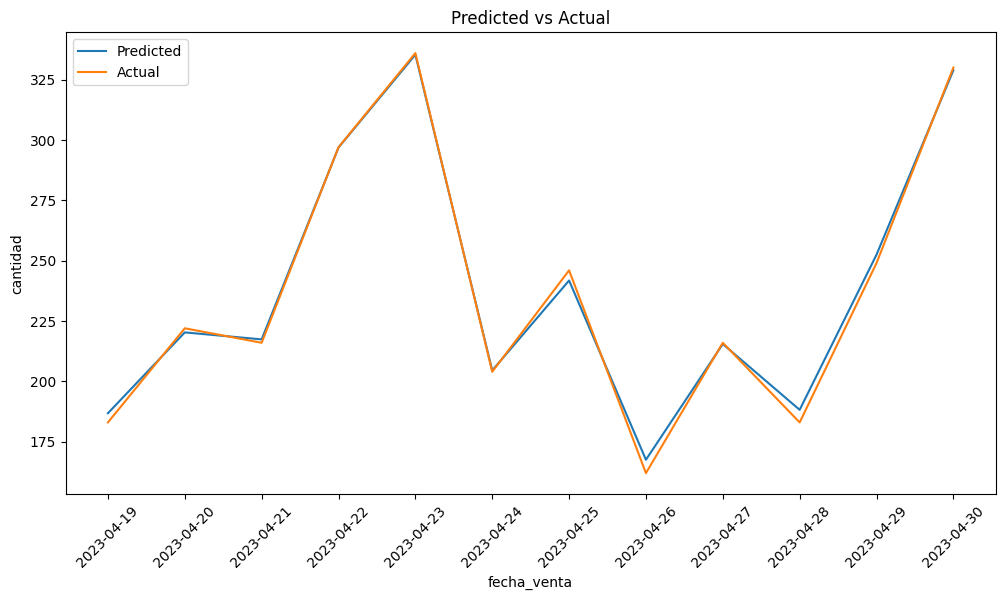

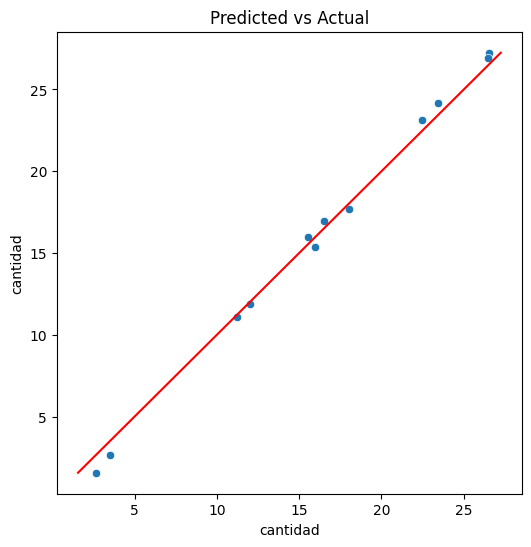

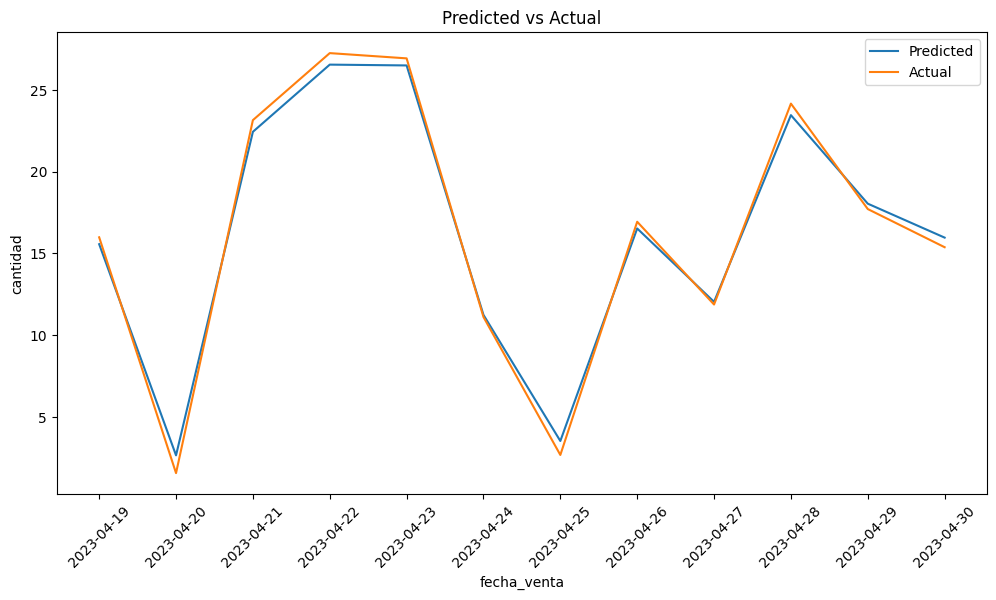

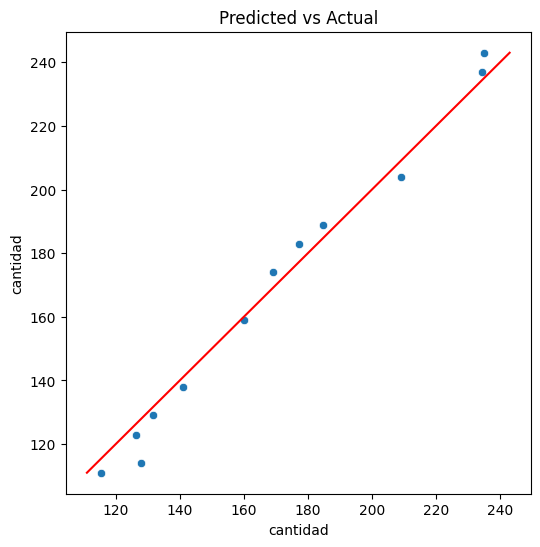

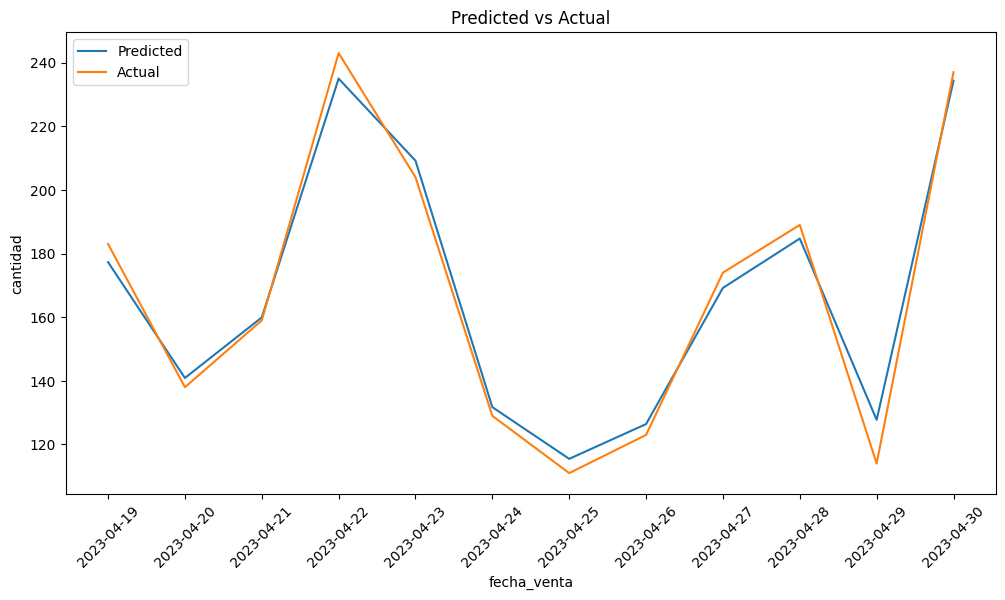

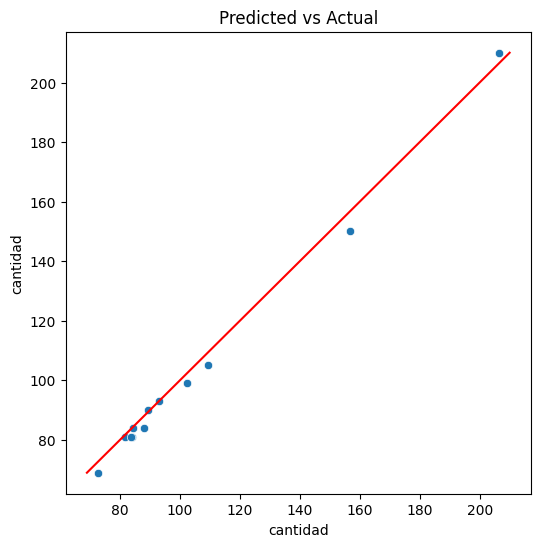

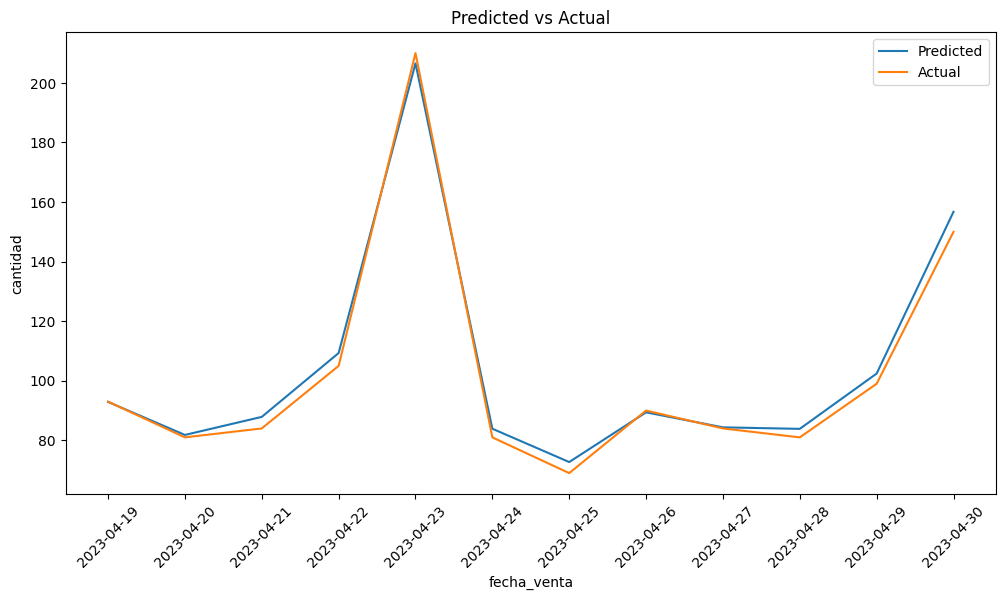

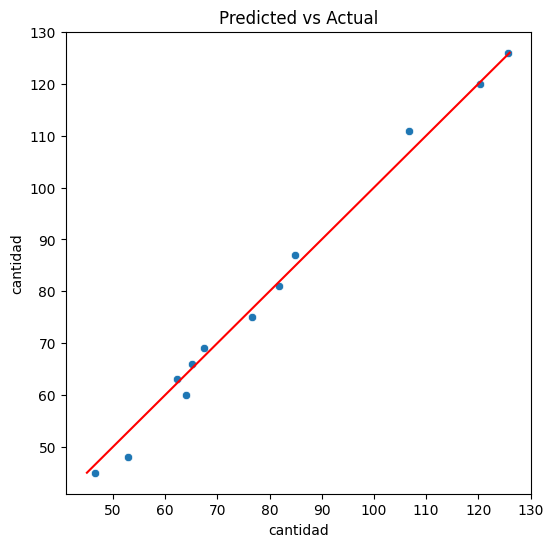

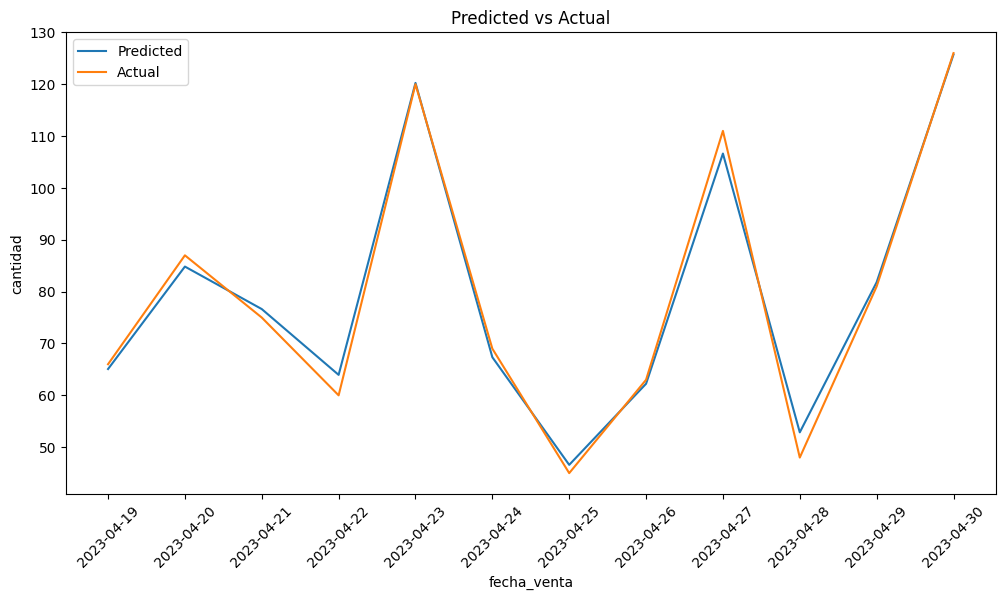

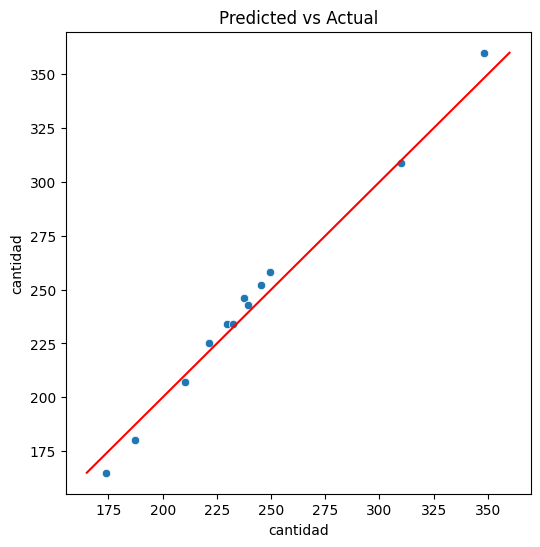

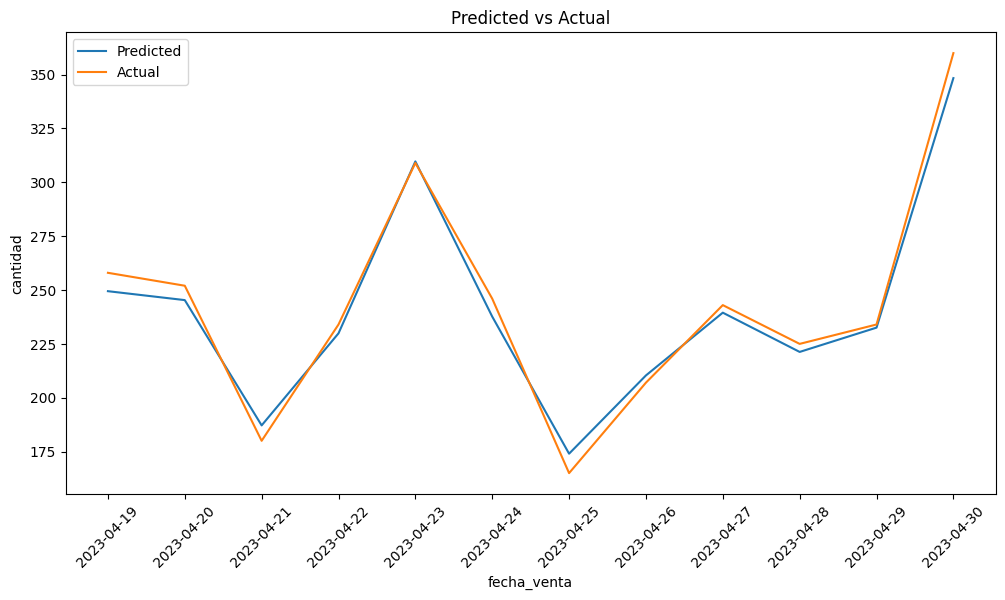

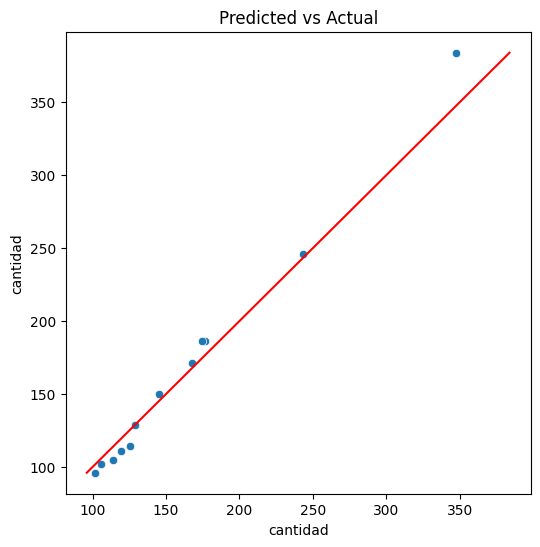

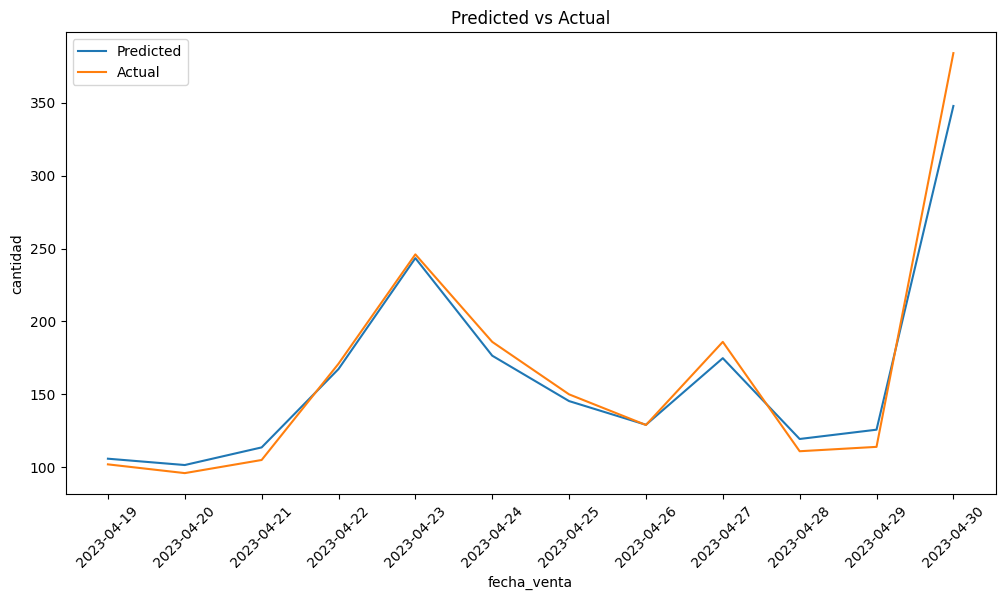

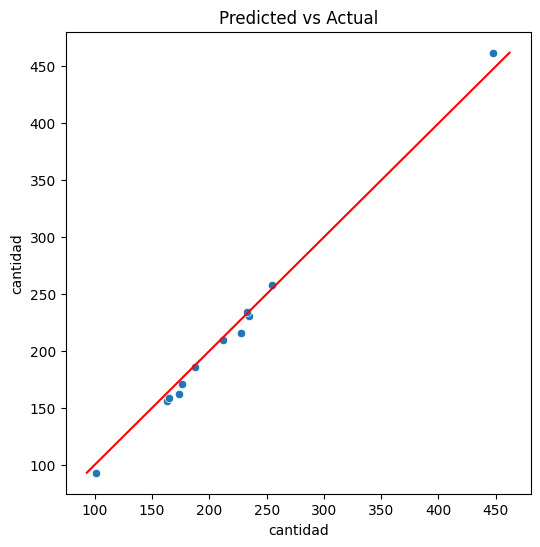

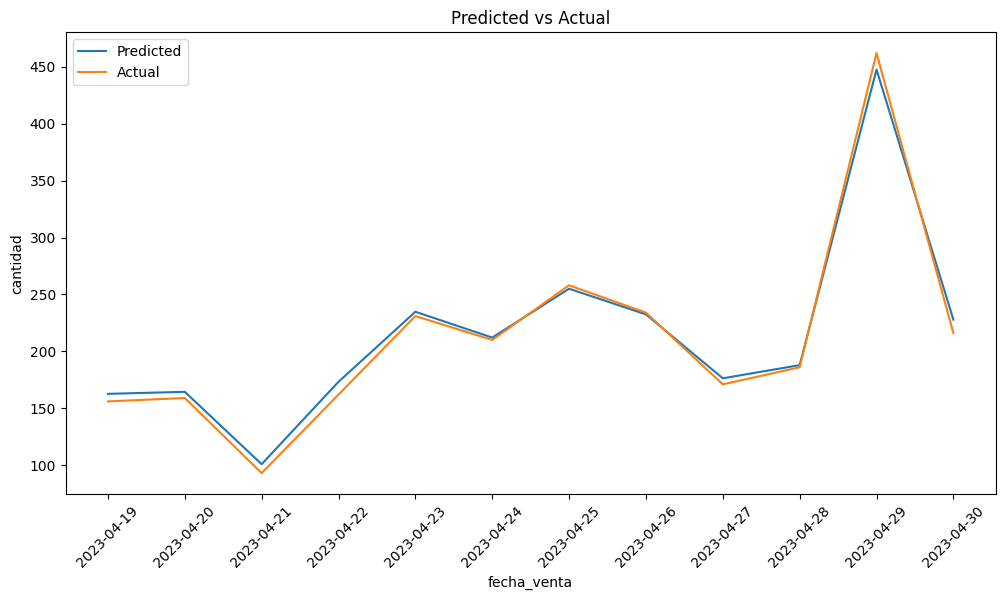

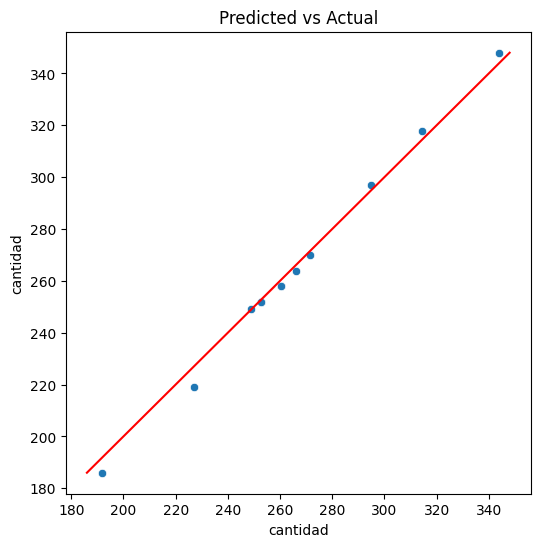

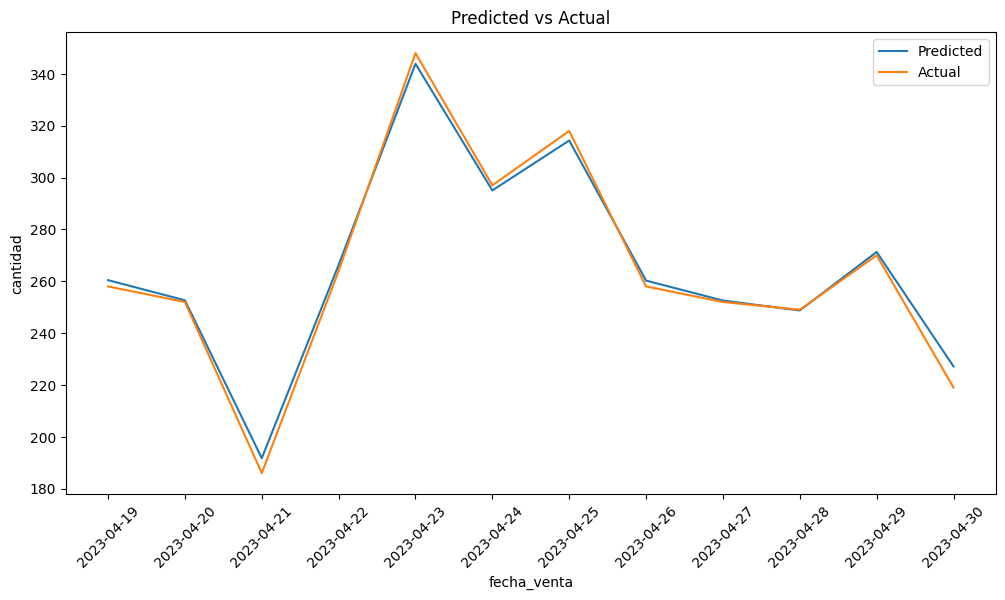

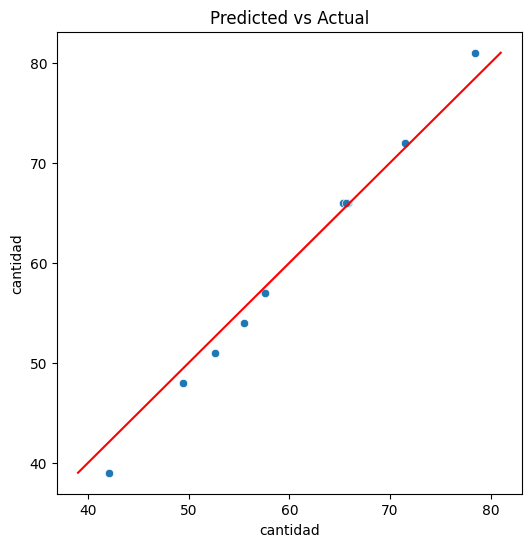

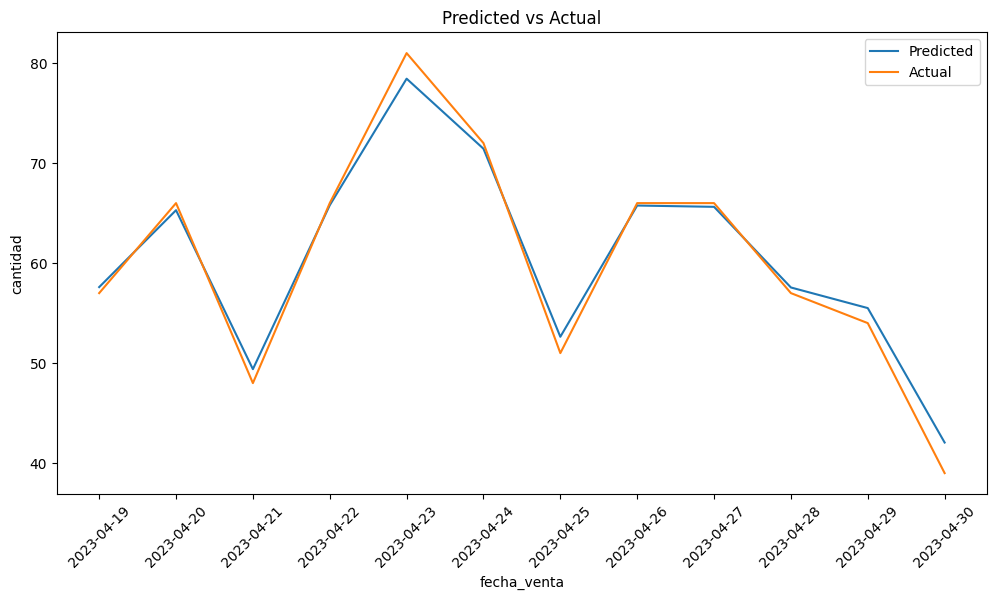

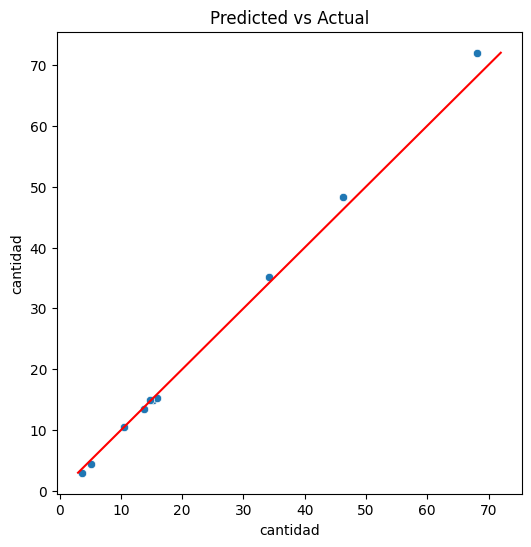

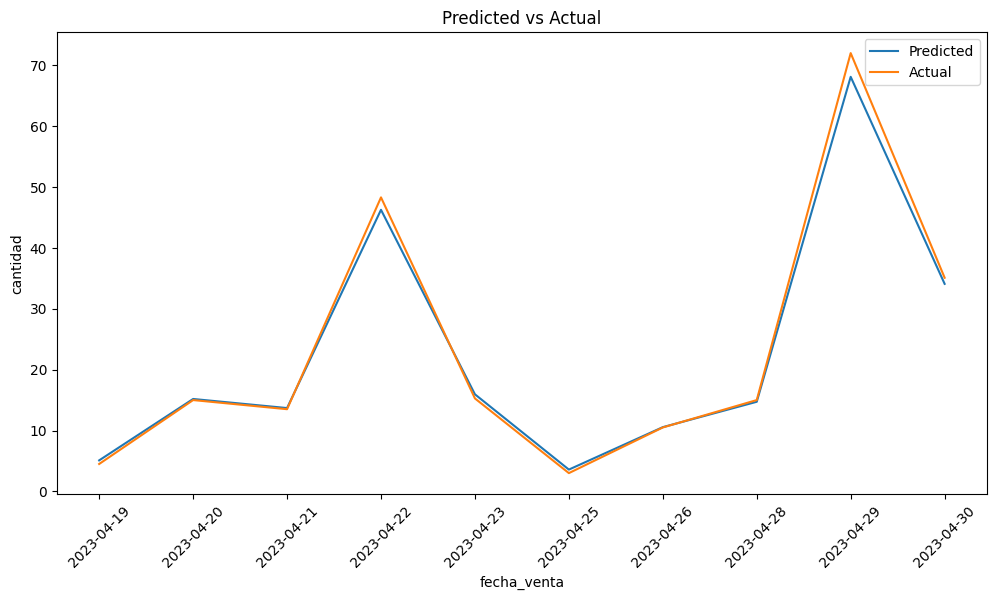

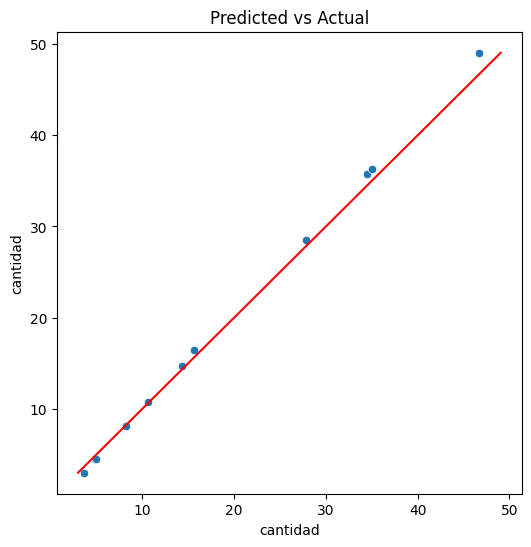

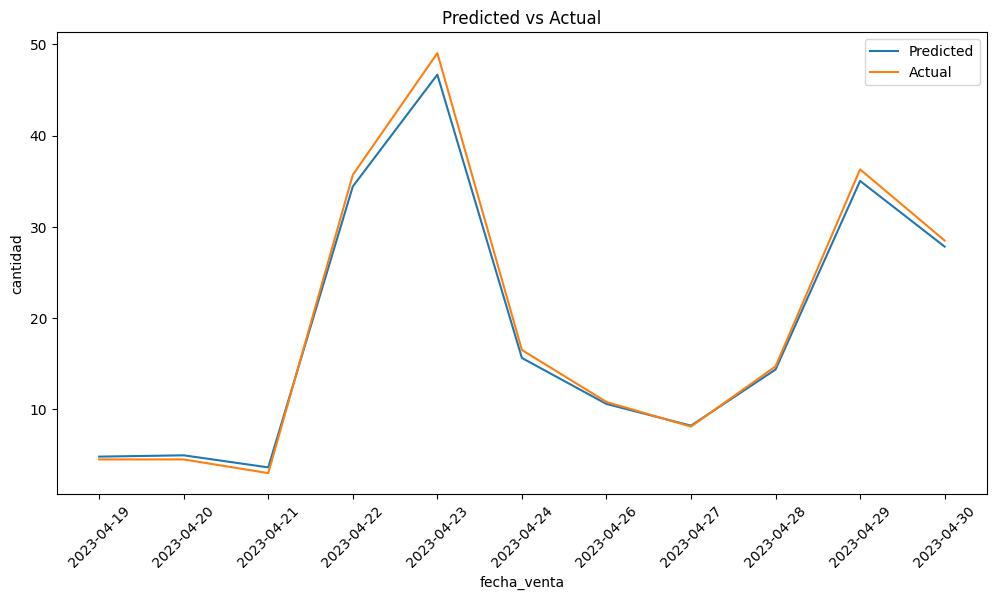

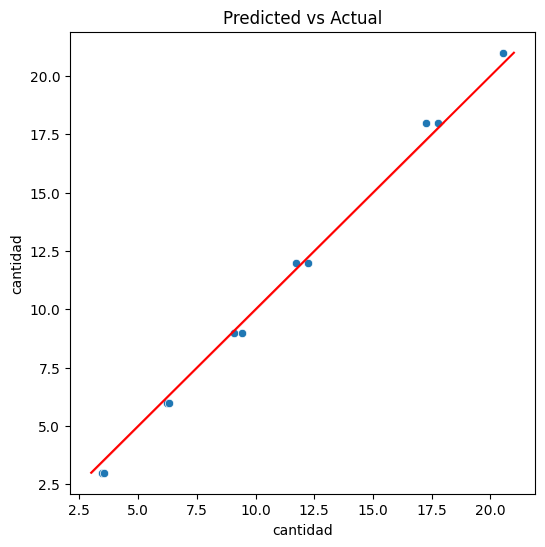

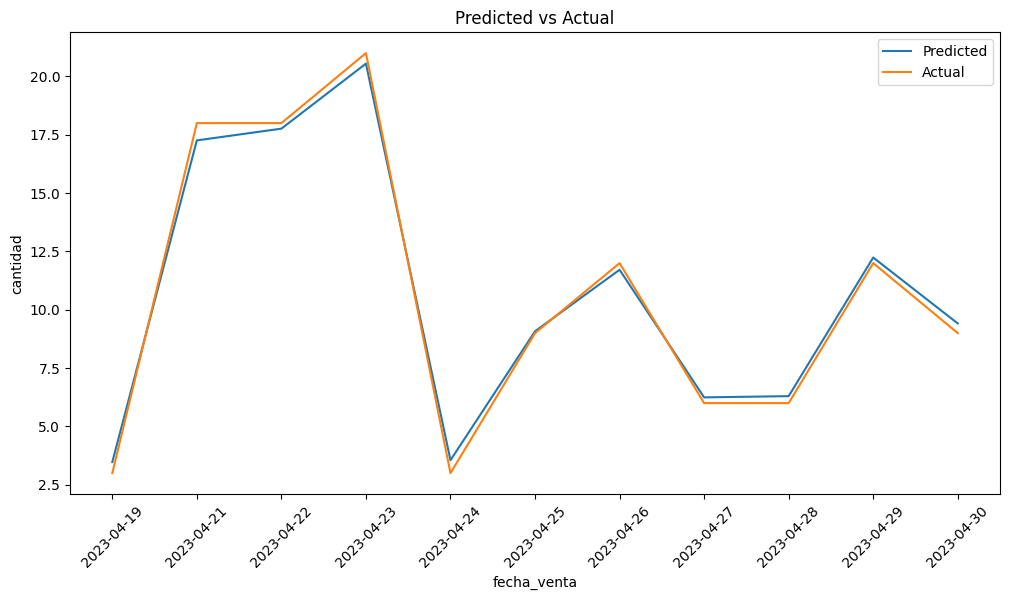

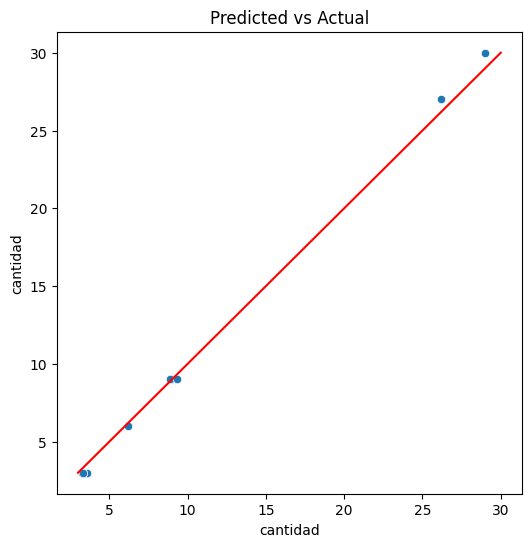

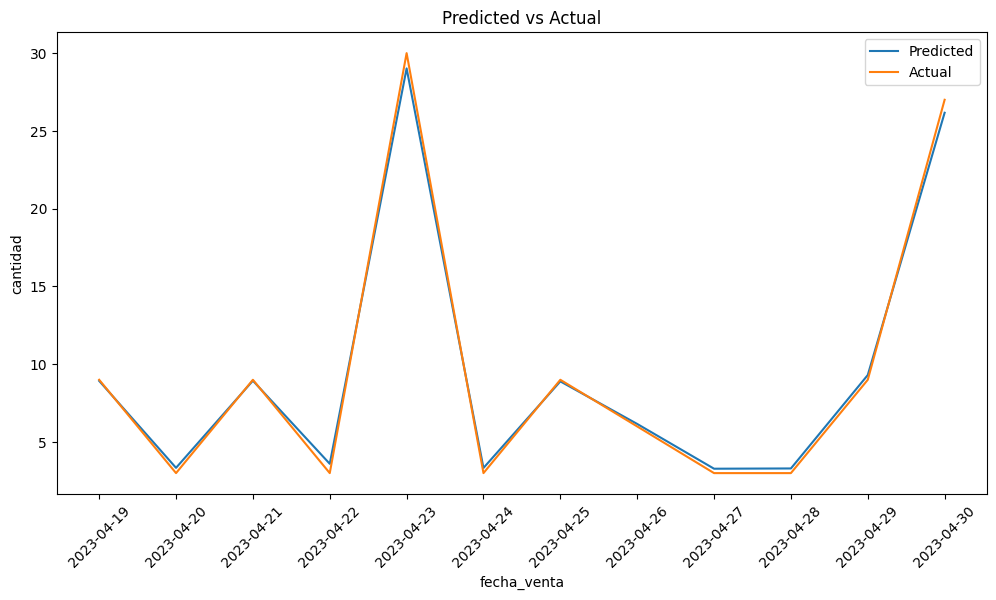

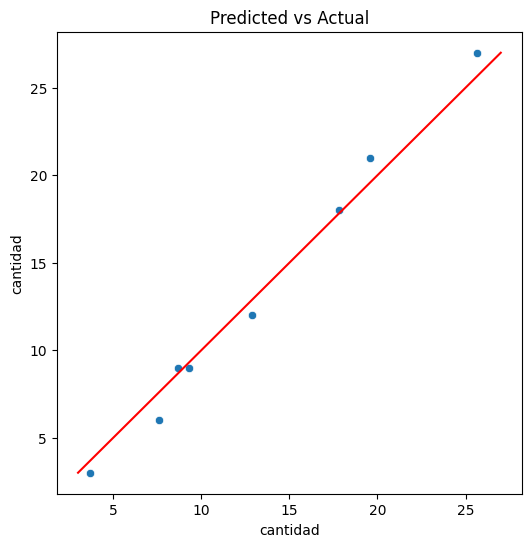

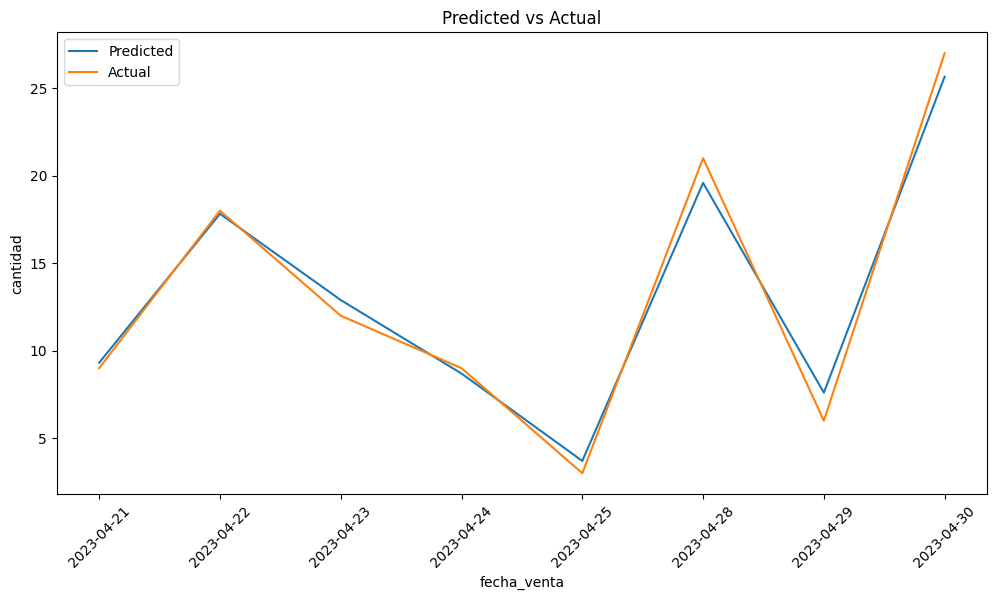

In [26]:
# Entrenamiento por cada producto
for PRODUCT_ID in PRODUCTS:
    # Filtramos el DataFrame para quedarnos solo con el producto actual
    df_pid = df[df["articulo"] == PRODUCT_ID].copy()
    
    # Separamos columnas numéricas y categóricas
    numerical_cols_existing = df_pid.select_dtypes(include='number').columns.tolist()
    categorical_cols_existing = df_pid.select_dtypes(exclude='number').columns.tolist()
    feature_cols = numerical_cols_existing + categorical_cols_existing  # todas juntas

    # División entre train y test según la fecha de corte
    X_train = df_pid.loc[df_pid["fecha_venta"] < horizont, feature_cols]
    y_train = df_pid.loc[df_pid["fecha_venta"] < horizont, "cantidad"]
    X_test = df_pid.loc[df_pid["fecha_venta"] >= horizont, feature_cols]
    y_test = df_pid.loc[df_pid["fecha_venta"] >= horizont, "cantidad"]

    # Entrenamiento y log con MLflow
    with mlflow.start_run() as run:
        mlflow.set_tag("product_id", PRODUCT_ID)

        # Entrenamos el pipeline final
        final_pipeline.fit(X_train, y_train)
        y_pred = final_pipeline.predict(X_test)

        # Métricas
        mae = metrics.mean_absolute_error(y_test, y_pred)
        r2 = metrics.r2_score(y_test, y_pred)
        mlflow.log_metric('mae', mae)
        mlflow.log_metric('r2', r2)
        print(f"Producto {PRODUCT_ID} -> MAE: {mae:.2f}, R²: {r2:.2f}")

        # Guardar modelo en disco
        model_path = f"product_models/model_{PRODUCT_ID}.pkl"
        joblib.dump(final_pipeline, model_path)
        manifest["products"][str(PRODUCT_ID)] = {
            "model_relpath": model_path,
            "feature_cols": feature_cols
        }

        # Guardar predicciones y columnas de identificación
        df_preds = X_test.copy()
        df_preds["familia"] = df_pid["familia"].iloc[0] if "familia" in df_pid.columns else None
        df_preds["articulo"] = PRODUCT_ID
        df_preds["y_true"] = y_test.values
        df_preds["y_pred"] = y_pred

        all_predictions.append(df_preds)

        # Gráfico Predicted vs Actual (scatter)
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_title("Predicted vs Actual")
        sns.scatterplot(x=y_pred, y=y_test, ax=ax)
        sns.lineplot(x=y_test, y=y_test, color="red", ax=ax)
        path_scatter = f'product_models/pred_vs_actual_{PRODUCT_ID}.png'
        plt.savefig(path_scatter)
        mlflow.log_artifact(path_scatter)

        # Gráfico Predicted vs Actual (timeline)
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_title("Predicted vs Actual")
        dates = X_test["fecha_venta"].astype(str)
        sns.lineplot(x=dates, y=y_pred, label="Predicted")
        sns.lineplot(x=dates, y=y_test, label="Actual")
        plt.xticks(rotation=45)
        path_timeline = f'product_models/pred_vs_actual_timeline_{PRODUCT_ID}.png'
        plt.savefig(path_timeline)
        mlflow.log_artifact(path_timeline)

# Guardar manifest con todos los modelos y columnas
with open("product_models/manifest.json", "w") as f:
    json.dump(manifest, f, indent=2)

# Unir todas las predicciones de todos los productos en un solo DataFrame
all_predictions_df = pd.concat(all_predictions, ignore_index=True)


## 5. Ensemble de modelos por producto

En esta sección se integran los modelos individuales entrenados para cada producto en un único ensemble. Cada modelo predice la cantidad vendida de su producto correspondiente utilizando el pipeline de transformación de datos definido previamente. Al combinar todos los modelos, se obtiene una solución unificada que permite realizar predicciones automáticas y consistentes para todos los productos seleccionados, facilitando el análisis y la evaluación conjunta del desempeño del sistema de predicción.

In [27]:
class MLflowProductEnsemble(mlflow.pyfunc.PythonModel):
    
    # Carga de modelos y manifiesto cuando se inicia el ensemble
    def load_context(self, context):
        # Leer el archivo manifest.json que lista todos los modelos y columnas
        manifest_path = context.artifacts["manifest"]
        with open(manifest_path, "r") as f:
            self.manifest = json.load(f)
        
        self.models = {}    # Diccionario para guardar cada modelo por PRODUCT_ID
        self.features = {}  # Diccionario para guardar columnas requeridas por cada modelo
        
        # Iteramos por cada producto en el manifest
        for pid, meta in self.manifest["products"].items():
            # Cargamos el modelo correspondiente
            model_path = context.artifacts[f"model_{pid}"]
            self.models[int(pid)] = joblib.load(model_path)
            # Guardamos también las columnas que necesita
            self.features[int(pid)] = meta["feature_cols"]

    # Método para predecir sobre un DataFrame de entrada
    def predict(self, context, model_input: pd.DataFrame):
        # Validación: necesitamos columna 'articulo' para saber qué modelo usar
        if "articulo" not in model_input.columns:
            raise ValueError("Se requiere columna 'articulo'")
        
        # Creamos un Series vacío para guardar predicciones
        preds = pd.Series(index=model_input.index, dtype=float)
        
        # Iteramos por cada producto en el DataFrame
        for pid, group in model_input.groupby("articulo"):
            pid = int(pid)
            
            # Validamos que tengamos modelo para ese producto
            if pid not in self.models:
                raise ValueError(f"No hay modelo para PRODUCT_ID {pid}")
            
            # Columnas que el modelo necesita
            needed_cols = self.features[pid]
            missing = [c for c in needed_cols if c not in group.columns]
            
            # Si faltan columnas, las agregamos con NaN
            if missing:
                group = group.copy()
                for c in missing:
                    group[c] = np.nan
            
            # Seleccionamos solo las columnas necesarias
            X = group[needed_cols].copy()
            
            # Convertimos enteros a float64 por compatibilidad
            int_cols = X.select_dtypes(include=["int","int32","int64"]).columns
            X[int_cols] = X[int_cols].astype("float64")
            
            # Guardamos predicciones en el Series
            preds.loc[group.index] = self.models[pid].predict(X)
        
        # Devolvemos predicciones como array
        return preds.values


In [28]:
# Primero preparamos los artifacts para MLflow
artifacts = {"manifest": "product_models/manifest.json"}

# Añadimos cada modelo individual al diccionario de artifacts
for pid in manifest["products"].keys():
    artifacts[f"model_{pid}"] = f"product_models/model_{pid}.pkl"

# Iniciamos una ejecución de MLflow
with mlflow.start_run(run_name="ensemble_wrapper") as run:
    
    # Tomamos un ejemplo de PRODUCT_ID para crear un input_example
    example_pid = int(next(iter(manifest["products"].keys())))
    example_feats = manifest["products"][str(example_pid)]["feature_cols"]
    
    # Creamos un DataFrame con NaN para todas las columnas que requiere el modelo,
    # y añadimos la columna 'articulo' para que el ensemble sepa qué modelo usar
    input_example = pd.DataFrame([{**{c: np.nan for c in example_feats}, "articulo": example_pid}])
    
    # 🔹 Registramos nuestro ensemble como un modelo MLflow
    mlflow.pyfunc.log_model(
        artifact_path="ensemble_model",      # Carpeta donde se guardará
        python_model=MLflowProductEnsemble(), # Nuestra clase ensemble
        artifacts=artifacts,                  # Todos los modelos + manifest
        input_example=input_example           # Ejemplo de input para MLflow
    )
    
    # Guardamos el run_id para referencia
    ensemble_run_id = run.info.run_id
    print("Ensemble run id:", ensemble_run_id)
    
    # Registramos el modelo en el MLflow Registry
    model_uri = f"runs:/{ensemble_run_id}/ensemble_model"
    registered = mlflow.register_model(model_uri=model_uri, name="Datathon")
    print("Registrado como:", f"models:/Datathon/{registered.version}")


2025/08/28 13:03:37 INFO mlflow.pyfunc: Inferring model signature from input example
2025/08/28 13:03:37 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: DTypePromotionError("The DType <class 'numpy.dtypes.Float64DType'> could not be promoted by <class 'numpy.dtypes.DateTime64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.DateTime64DType'>)"). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.


2025/08/28 13:03:41 WARNING mlflow.utils.requirements_utils: Failed to run predict on input_example, dependencies introduced in predict are not captured.
DTypePromotionError("The DType <class 'numpy.dtypes.Float64DType'> could not be promoted by <class 'numpy.dtypes.DateTime64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.DateTime64DType'>)")Traceback (most recent call last):
  File "/opt/conda/envs/venv/lib/python3.11/site-packages/mlflow/utils/_capture_modules.py", line 166, in load_model_and_predict
    model.predict(input_example, params=params)
  File "/opt/conda/envs/venv/lib/python3.11/site-packages/mlflow/pyfunc/model.py", line 1175, in predict
    return self.python_model.predict(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/envs/venv/lib/python3.11/site-packages/mlflow/pyfunc

Ensemble run id: a89aaa66a82a4e26a2ed3a03e08eef56
Registrado como: models:/Datathon/1
🏃 View run ensemble_wrapper at: http://localhost:5000/#/experiments/325443221124704435/runs/a89aaa66a82a4e26a2ed3a03e08eef56
🧪 View experiment at: http://localhost:5000/#/experiments/325443221124704435


Created version '1' of model 'Datathon'.


El ensemble final de modelos fue registrado en MLflow bajo el nombre Datathon, generando la versión 1. Esto asegura que todos los modelos individuales queden centralizados y permite un seguimiento y despliegue controlado en producción. El registro queda disponible como models:/Datathon/1.

## 6. Productivización del modelo


Tras registrar el ensemble como models:/Datathon/1 (versión 1 del modelo) en MLflow, procedimos a su productivización. Construimos una imagen Docker del modelo y la ejecutamos localmente, dejando el modelo listo para recibir predicciones de manera productiva.

export MLFLOW_TRACKING_URI=http://localhost:5000

mlflow models build-docker --model-uri models:/Datathon/1 --name datathon

docker run -p 5001:8080 datathon

```bash
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
INFO:     Started parent process [13]
172.17.0.1 - - [28/Aug/2025:08:25:15 +0000] "GET / HTTP/1.1" 404 2 "-" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/139.0.0.0 Safari/537.36 Edg/139.0.0.0"
INFO:     Started server process [19]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Started server process [18]
INFO:     Waiting for application startup.
INFO:     Application startup complete.

```

docker images
```bash
REPOSITORY   TAG       IMAGE ID       CREATED              SIZE
datathon     latest    da7517bb5d66   About a minute ago   3.95GB
```

## 7. Haz peticiones al modelo

Una vez que el modelo está productivizado, se expone a través de un servidor local usando MLflow. Esto permite hacer peticiones al modelo mediante solicitudes HTTP, obteniendo predicciones de manera inmediata y automatizada.

export MLFLOW_TRACKING_URI=http://localhost:5000

mlflow models serve -m models:/Datathon/1 --env-manager conda --port 5001

```bash
INFO:     Started server process [26620]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:5001 (Press CTRL+C to quit)
INFO:     127.0.0.1:40606 - "GET /version HTTP/1.1" 200 OK
INFO:     127.0.0.1:40618 - "GET /health HTTP/1.1" 200 OK
INFO:     127.0.0.1:40632 - "GET /ping HTTP/1.1" 200 OK
INFO:     127.0.0.1:40642 - "POST /invocations HTTP/1.1" 200 OK
```

In [29]:
# Aseguramos que la columna de fechas esté en formato string
all_predictions_df['fecha_venta'] = all_predictions_df['fecha_venta'].astype(str)

# Creamos el payload con todos los registros de X_test
payload = {
    "dataframe_split": {
        "columns": all_predictions_df.columns.tolist(),  # nombres de columnas
        "data": all_predictions_df.values.tolist()      # datos como lista de listas
    }
}

# Endpoints del servidor del modelo
BASE_URL = "http://127.0.0.1:5001"
headers = {"Content-Type": "application/json"}

# Comprobar versión del modelo en el servidor
version_resp = requests.get(f"{BASE_URL}/version")
print("Versión:", version_resp.text)

# Comprobar estado del servidor
health_resp = requests.get(f"{BASE_URL}/health")
print("Estado:", health_resp.text)

# Comprobar ping del servidor
ping_resp = requests.get(f"{BASE_URL}/ping")
print("Ping:", ping_resp.text)

# Petición POST para obtener predicciones
response = requests.post(f"{BASE_URL}/invocations", headers=headers, json=payload)

try:
    # Intentamos leer la respuesta en formato JSON
    result = response.json()
    if "predictions" in result:
        # Si la respuesta tiene predicciones, las guardamos
        predictions = result["predictions"]
        print("Predicciones:", predictions)
    else:
        # Si no hay 'predictions', mostramos la respuesta completa para revisar
        print("No hay 'predictions', revisa el formato de la respuesta:", result)
except Exception as e:
    # Capturamos cualquier error al parsear el JSON
    print("Error al parsear JSON:", e)


Versión: 2.22.1
Estado: 

Ping: 

Predicciones: [186.80573693137546, 220.29832037602927, 217.40386825636907, 296.8927014204939, 335.3432015572241, 204.52385625272478, 241.79184115055065, 167.53770996617675, 215.4823131990323, 188.2153387743621, 252.4929907317311, 328.90057236865755, 15.563329795300154, 2.6527899655438665, 22.434625929389767, 26.542131697264644, 26.49264197359442, 11.240266434958889, 3.5303797996777773, 16.523781459581592, 12.038116746215625, 23.45303736897351, 18.0414029228246, 15.96520128860395, 177.3060467103056, 140.89989374741592, 159.92948936848157, 234.9916192477821, 209.18880590983548, 131.73166863438374, 115.48216531683164, 126.41128942763699, 169.21042597548285, 184.72257535900064, 127.74093655856653, 234.33108783790925, 92.9007405560596, 81.8135824764688, 87.87554073592356, 109.3081492548385, 206.55536079465475, 83.89923013435298, 72.7159231136692, 89.4011512743419, 84.36520025166865, 83.85728526917892, 102.42307922036728, 156.72793050648855, 65.0734921949908

## 8. Sube tus resultados a la base de datos


Creamos un nuevo DataFrame que contiene únicamente la información relevante: fecha, familia, artículo y la cantidad predicha por el modelo. Este DataFrame se prepara para ser subido a la base de datos, permitiendo almacenar y consultar fácilmente los resultados de las predicciones.

In [30]:
# Creamos un nuevo DataFrame solo con las columnas que nos interesan:
df_article_prediction = pd.DataFrame({
    "fecha": all_predictions_df["fecha_venta"],
    "familia": all_predictions_df["familia"],
    "articulo": all_predictions_df["articulo"],
    "cantidad": all_predictions_df["y_pred"]  # usamos solo la predicción
})

# Mostramos el DataFrame completo para ver todas las filas y columnas
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_article_prediction)


          fecha     familia  articulo    cantidad
0    2023-04-19    BOLLERIA      3960  186.805737
1    2023-04-20    BOLLERIA      3960  220.298320
2    2023-04-21    BOLLERIA      3960  217.403868
3    2023-04-22    BOLLERIA      3960  296.892701
4    2023-04-23    BOLLERIA      3960  335.343202
5    2023-04-24    BOLLERIA      3960  204.523856
6    2023-04-25    BOLLERIA      3960  241.791841
7    2023-04-26    BOLLERIA      3960  167.537710
8    2023-04-27    BOLLERIA      3960  215.482313
9    2023-04-28    BOLLERIA      3960  188.215339
10   2023-04-29    BOLLERIA      3960  252.492991
11   2023-04-30    BOLLERIA      3960  328.900572
12   2023-04-19    BOLLERIA      6425   15.563330
13   2023-04-20    BOLLERIA      6425    2.652790
14   2023-04-21    BOLLERIA      6425   22.434626
15   2023-04-22    BOLLERIA      6425   26.542132
16   2023-04-23    BOLLERIA      6425   26.492642
17   2023-04-24    BOLLERIA      6425   11.240266
18   2023-04-25    BOLLERIA      6425    3.530380


Después de preparar el DataFrame con las predicciones, nos conectamos a la base de datos usando nuestras credenciales. Creamos una tabla específica para almacenar los resultados y subimos el DataFrame con las predicciones, de modo que queden guardadas de forma organizada y accesible para análisis posteriores.

In [31]:
# Database credentials
DATABASE = "sandbox"
NAME = "Alina"  # ‼️ Cambia esta variable por tu nombre. 

table_name = f"Materials_Prediction_Group_{NAME}"

# Connect to the database
db = DatabaseConnection(DB_USERNAME, DB_PASSWORD, database=DATABASE)
db.insert_dataframe(df_article_prediction, table_name)